### Experimenting with Chr12 induced pairwise SVs 

The aim is to perform an in-depth study of the pairwise SVs for chr12, performing planned downstream analysis at multiple pairwise distance thresholds and for triangles, trapezoids, and parallelograms 

In [1]:
# Import statements
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob


In [2]:
### This function reads in the SV bed files into a pandas DF for a given clade. 

def read_sv_bed_files(clade, chr, bed_folder):
    """
    Read all .bed files in a folder and add a 'clade' column to the data frame
    Each bed file has columns:
        sample1, start, end, sample2, start, end, type, diff
    """
    all_beds = []
    bed_files = [f for f in os.listdir(bed_folder) if f.endswith(".bed")]
    print(f"Found {len(bed_files)} SV bed files for clade '{clade}'")

    # Ensure folder exists
    if not os.path.isdir(bed_folder):
        raise FileNotFoundError("Folder not found for clade '{}': {}".format(clade, bed_folder))

    for filename in os.listdir(bed_folder):
        if filename.endswith(".bed"):
            bed_path = os.path.join(bed_folder, filename)
            try:
                df = pd.read_csv(
                    bed_path,
                    sep="\t",
                    header=None,
                    names=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff"]
                )
                df["clade"] = clade
                df["chr"] = chr
                df["source_file"] = filename  # optional, helps track origin
                df["length"] = np.where(
                    df["type"] == "I",
                    df["end2"] - df["start2"],  # insertion → use sample2 coords
                    df["end1"] - df["start1"]  # otherwise (deletion) → sample1 coords
                )
                all_beds.append(df)
            except Exception as e:
                print("Warning: Could not read {}: {}".format(bed_path, e))

    if all_beds:
        return pd.concat(all_beds, ignore_index=True)
    else:
        print("Warning: No .bed files found in {} for clade '{}'".format(bed_folder, clade))
        return pd.DataFrame(columns=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff", "clade", "source_file","chr"])

In [3]:
### read SV calls from both chr12 subgroups into dataframe and merge 
all_data = []
subgroup0 = read_sv_bed_files("subgroup_0", "chr12", "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/SV_beds/chr12_subgroup0")
all_data.append(subgroup0)
subgroup1 = read_sv_bed_files("subgroup_1", "chr12", "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/SV_beds/chr12_subgroup1")
all_data.append(subgroup1)

induced_df=pd.concat(all_data, ignore_index=True)

Found 17205 SV bed files for clade 'subgroup_0'
Found 17391 SV bed files for clade 'subgroup_1'


In [4]:
### Add pairwise distances as an additional column in the datafram 
pairwise_dist="/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/chr12_r2_QC_v2_centrolign_pairwise_distance.csv"

pairwise_df = pd.read_csv(pairwise_dist)
pairwise_df["chr"] = "chr12"
pairwise_df['dist'] = pairwise_df['dist'].astype(float)

# Sort sample pairs so ordering doesn't matter
df_dist_sorted = pairwise_df.copy()
df_dist_sorted[['sample1', 'sample2']] = np.sort(df_dist_sorted[['sample1', 'sample2']], axis=1)

df_sv_sorted = induced_df.copy()
df_sv_sorted[['sample1', 'sample2']] = np.sort(df_sv_sorted[['sample1', 'sample2']], axis=1)

# Merge on sample1, sample2, AND chr
df_sv_sorted = df_sv_sorted.merge(df_dist_sorted, on=['sample1', 'sample2', 'chr'], how='left')

df_sv_sorted.head()


,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,dist
0,HG02738.1,2773,3791,NA18570.2,2773,2774,D,0.001961,subgroup_0,chr12,HG02738.1_NA18570.2.bed,1018,0.789033
1,HG02738.1,3791,3792,NA18570.2,2773,3793,I,0.001961,subgroup_0,chr12,HG02738.1_NA18570.2.bed,1020,0.789033
2,HG02738.1,3866,8818,NA18570.2,3868,3869,D,0.205977,subgroup_0,chr12,HG02738.1_NA18570.2.bed,4952,0.789033
3,HG02738.1,8818,8819,NA18570.2,3868,7800,I,0.205977,subgroup_0,chr12,HG02738.1_NA18570.2.bed,3932,0.789033
4,HG02738.1,10274,10614,NA18570.2,9256,9257,D,-1.000000,subgroup_0,chr12,HG02738.1_NA18570.2.bed,340,0.789033


/data/tmp/ipykernel_2520856/2037373049.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_sv_sorted.groupby(["sample1", "sample2", "dist_bin"]).agg(



=== Largest triangle–parallelogram difference per bin ===

Bin 0-0.2 (max diff = 329.0):
   NA18943.2 – NA18971.1: 333.0 triangles, 4.0 parallelograms (diff = 329.0)

Bin 0.2-0.4 (max diff = 354.0):
   HG00621.2 – NA20905.2: 360.0 triangles, 6.0 parallelograms (diff = 354.0)

Bin 0.4-0.6 (max diff = 415.0):
   HG03209.2 – NA20129.2: 421.0 triangles, 6.0 parallelograms (diff = 415.0)

Bin 0.6-0.8 (max diff = 326.0):
   HG00321.1 – NA18944.2: 326.0 triangles, 0.0 parallelograms (diff = 326.0)

Bin 0.8-1.0 (max diff = 206.0):
   HG02109.1 – HG02717.1: 210.0 triangles, 4.0 parallelograms (diff = 206.0)



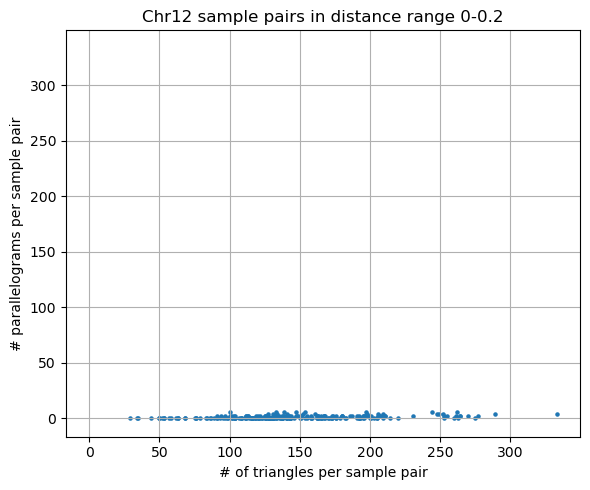

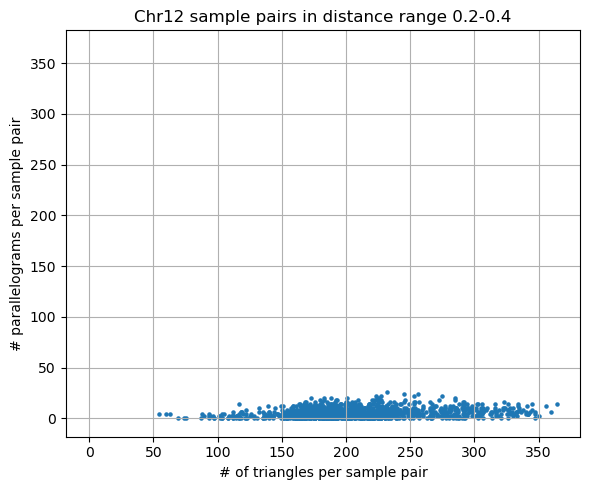

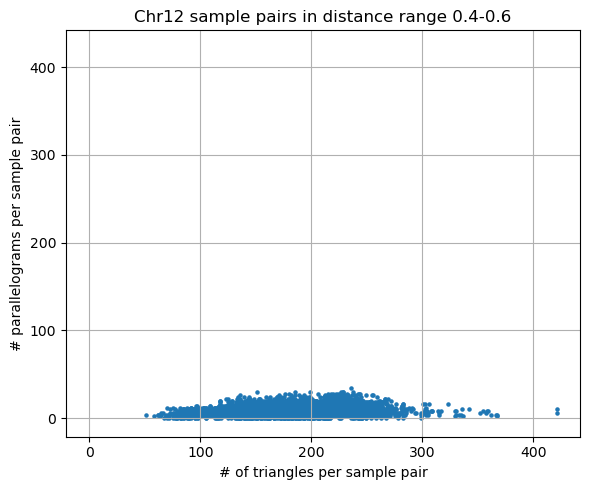

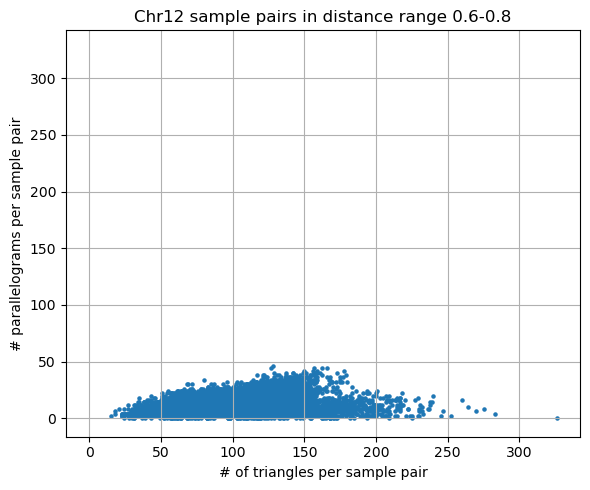

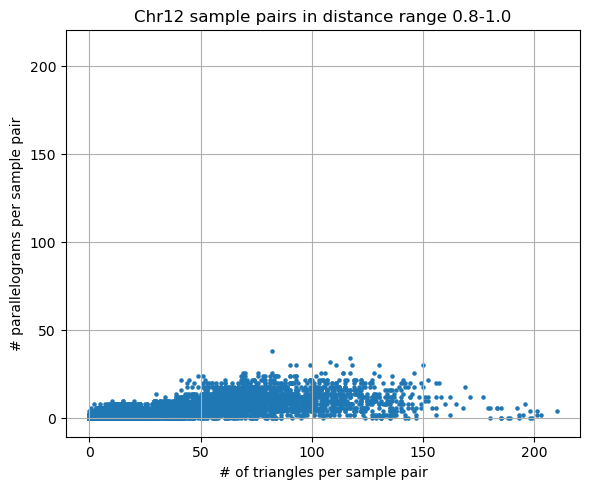

In [10]:
# Try to get a sense of whether all samples have the same ratio of parallelograms to triangles, or if their = number 
# is dominated by a few samples 

# Define bins
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1.0"]

df_sv_sorted["dist_bin"] = pd.cut(df_sv_sorted["dist"], bins=bins, labels=labels, include_lowest=True)

# Count events for each sample pair
grouped = df_sv_sorted.groupby(["sample1", "sample2", "dist_bin"]).agg(
    x_events=("diff", lambda s: (s == -1).sum()),
    y_events = ("diff", lambda s: ((s > 0) & (s < 0.1)).sum())
).reset_index()

# Compute absolute difference between triangles and parallelograms 
grouped["abs_diff"] = (grouped["x_events"] - grouped["y_events"]).abs()

# print largest sample pairs for each to spot check correctness of code
print("\n=== Largest triangle–parallelogram difference per bin ===\n")

for bin_label in labels:
    subset = grouped[grouped["dist_bin"] == bin_label]
    
    if subset.empty:
        print(f"Bin {bin_label}: no data")
        continue
    
    max_diff = subset["abs_diff"].max()
    biggest = subset[subset["abs_diff"] == max_diff]

    print(f"Bin {bin_label} (max diff = {max_diff}):")
    for _, row in biggest.iterrows():
        print(f"   {row['sample1']} – {row['sample2']}: "
              f"{row['x_events']} triangles, "
              f"{row['y_events']} parallelograms "
              f"(diff = {row['abs_diff']})")
    print()

#print(grouped.tail(6))
# Scatter plots for each bin
for bin_label in labels:
    subset = grouped[grouped["dist_bin"] == bin_label]
    
    if subset.empty:
        continue
    
    plt.figure(figsize=(6,5))
    plt.scatter(subset["x_events"], subset["y_events"], s=5)

    #  dynamic equal axis ranges 
    min_val = min(subset["x_events"].min(), subset["y_events"].min())
    max_val = max(subset["x_events"].max(), subset["y_events"].max())

    # Add a small padding
    padding = (max_val - min_val) * 0.05
    plt.xlim(min_val - padding, max_val + padding)
    plt.ylim(min_val - padding, max_val + padding)

    plt.xlabel("# of triangles per sample pair")
    plt.ylabel("# parallelograms per sample pair")
    plt.title(f"Chr12 sample pairs in distance range {bin_label}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/data/tmp/ipykernel_2520856/3624569667.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_sv_sorted.groupby(["sample1", "sample2", "dist_bin"]).agg(


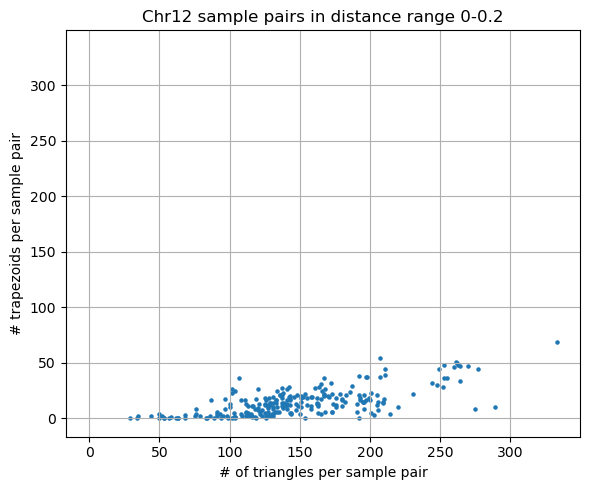

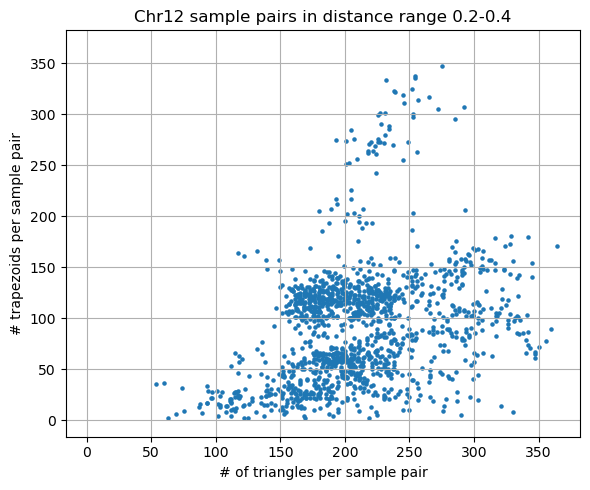

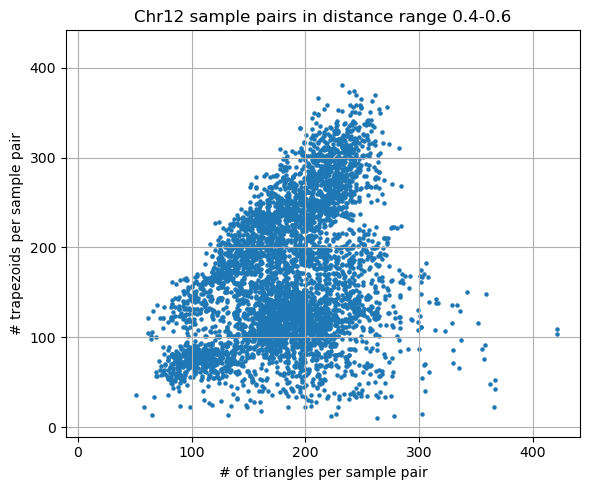

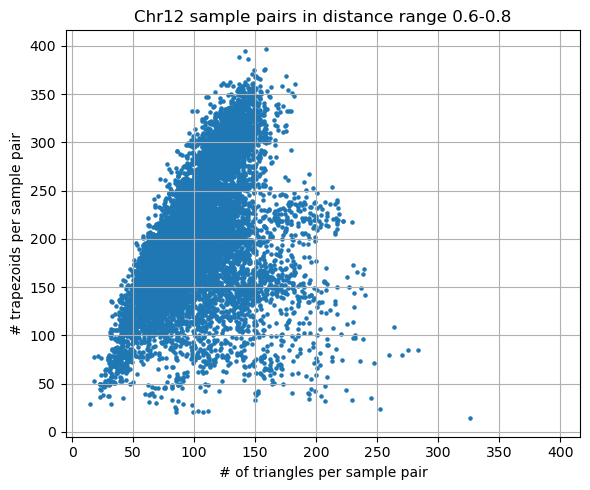

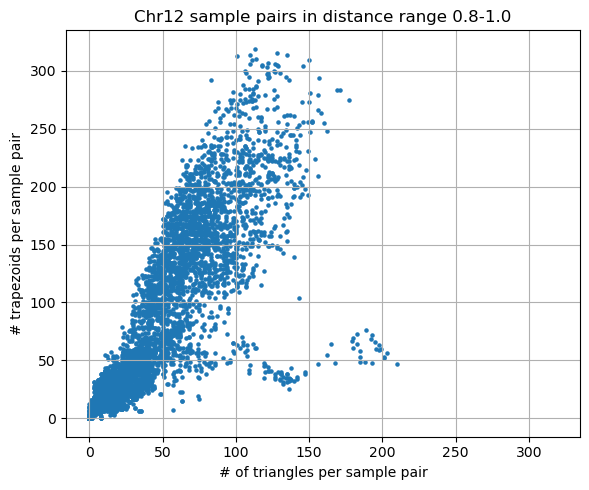

In [12]:
# Try to get a sense of whether all samples have the same ratio of parallelograms to trapezoids, or if their = number 
# is dominated by a few samples 

# Define bins
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1.0"]

df_sv_sorted["dist_bin"] = pd.cut(df_sv_sorted["dist"], bins=bins, labels=labels, include_lowest=True)

# Count events for each sample pair
grouped = df_sv_sorted.groupby(["sample1", "sample2", "dist_bin"]).agg(
    x_events=("diff", lambda s: (s == -1).sum()),
    y_events = ("diff", lambda s: (s > 0.1 ).sum())
).reset_index()

# Compute absolute difference between triangles and parallelograms 
grouped["abs_diff"] = (grouped["x_events"] - grouped["y_events"]).abs()

#print(grouped.tail(6))
# Scatter plots for each bin
for bin_label in labels:
    subset = grouped[grouped["dist_bin"] == bin_label]
    
    if subset.empty:
        continue
    
    plt.figure(figsize=(6,5))
    plt.scatter(subset["x_events"], subset["y_events"], s=5)

    #  dynamic equal axis ranges 
    min_val = min(subset["x_events"].min(), subset["y_events"].min())
    max_val = max(subset["x_events"].max(), subset["y_events"].max())

    # Add a small padding
    padding = (max_val - min_val) * 0.05
    plt.xlim(min_val - padding, max_val + padding)
    plt.ylim(min_val - padding, max_val + padding)

    plt.xlabel("# of triangles per sample pair")
    plt.ylabel("# trapezoids per sample pair")
    plt.title(f"Chr12 sample pairs in distance range {bin_label}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Contextualize chr 12 calls by local identity

In [4]:
### Read in pairwise distances
pairwise_dist="/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/chr12_r2_QC_v2_centrolign_pairwise_distance.csv"

pairwise_df = pd.read_csv(pairwise_dist)
pairwise_df["chr"] = "chr12"
pairwise_df['dist'] = pairwise_df['dist'].astype(float)

pairwise_df.head()

,sample1,sample2,dist,chr
0,HG01993.2,HG02841.1,1.000000,chr12
1,HG03098.1,HG03784.1,0.999964,chr12
2,HG01960.2,NA20762.1,0.681127,chr12
3,HG00133.1,HG01192.2,0.999849,chr12
4,HG00126.2,HG01106.2,0.999994,chr12


In [ ]:
# read in bed files containing percent of SV bases at each local identity window - subgroup 1 
folder1="/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/SV_beds/local_identity/chr12_subgroup_1/"
folder2="/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/SV_beds/local_identity/chr12_subgroup_0/"

folders = [folder1, folder2]

# Expected BED column names
columns = [
    "contig", "start", "end", "region", "local_identity", "strand",
    "start2", "end2", "rgb", "parallelograms", "trapezoids", "triangles"
]

dfs = []

for folder in folders:
    for fname in os.listdir(folder):
        if fname.endswith(".local_identity_SV_counts.bed"):

            # Extract sample1 and sample2
            base = fname.replace(".local_identity_SV_counts.bed", "")
            sample1, sample2 = base.split("_", 1)

            # Full path
            path = os.path.join(folder, fname)

            # Read the BED into a dataframe
            df = pd.read_csv(path, sep="\t", header=None, names=columns)

            # Add metadata
            df["sample1"] = sample1
            df["sample2"] = sample2
            #df["source_folder"] = os.path.basename(folder)  # optional

            dfs.append(df)

# Combine everything
combined_df = pd.concat(dfs, ignore_index=True)

print(combined_df.head())

/data/tmp/ipykernel_2193045/3121236830.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dfs, ignore_index=True)


      contig  start    end    region  local_identity strand start2   end2  \
0  NA18508.1      1   5000  region_0           95.95      +      1   5000   
1  NA18508.1   5001  10000  region_1           96.56      +   5001  10000   
2  NA18508.1  10001  15000  region_2           96.86      +  10001  15000   
3  NA18508.1  15001  20000  region_3           97.01      +  15001  20000   
4  NA18508.1  20001  25000  region_4           97.05      +  20001  25000   

         rgb parallelograms trapezoids triangles    sample1    sample2  \
0  94,79,162            352       1864         1  NA18508.1  HG03098.2   
1  94,79,162              0       1865       704  NA18508.1  HG03098.2   
2  94,79,162              0       4812         0  NA18508.1  HG03098.2   
3  92,81,163              0       4626         0  NA18508.1  HG03098.2   
4  87,87,166              0        228      2039  NA18508.1  HG03098.2   

  source_folder  
0                
1                
2                
3                
4 

In [7]:
print(len(combined_df))

37506276


In [9]:
## Merge pairwise dist and local identity dataframes 
# Sort sample pairs so ordering doesn't matter
df_dist_sorted = pairwise_df.copy()
df_dist_sorted[['sample1', 'sample2']] = np.sort(df_dist_sorted[['sample1', 'sample2']], axis=1)

df_local_sorted = combined_df.copy()
df_local_sorted[['sample1', 'sample2']] = np.sort(df_local_sorted[['sample1', 'sample2']], axis=1)

# Merge on sample1, sample2, AND chr
df_local_sorted = df_local_sorted.merge(df_dist_sorted, on=['sample1', 'sample2'], how='left')

df_local_sorted.head()

,contig,start,end,region,local_identity,strand,start2,end2,rgb,parallelograms,trapezoids,triangles,sample1,sample2,source_folder,dist,chr
0,NA18508.1,1,5000,region_0,95.95,+,1,5000,"94,79,162",352,1864,1,HG03098.2,NA18508.1,,0.97299,chr12
1,NA18508.1,5001,10000,region_1,96.56,+,5001,10000,"94,79,162",0,1865,704,HG03098.2,NA18508.1,,0.97299,chr12
2,NA18508.1,10001,15000,region_2,96.86,+,10001,15000,"94,79,162",0,4812,0,HG03098.2,NA18508.1,,0.97299,chr12
3,NA18508.1,15001,20000,region_3,97.01,+,15001,20000,"92,81,163",0,4626,0,HG03098.2,NA18508.1,,0.97299,chr12
4,NA18508.1,20001,25000,region_4,97.05,+,20001,25000,"87,87,166",0,228,2039,HG03098.2,NA18508.1,,0.97299,chr12


/data/tmp/ipykernel_2193045/3237246243.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df_subset.groupby("identity_bin")[["parallelograms", "trapezoids", "triangles"]].sum()


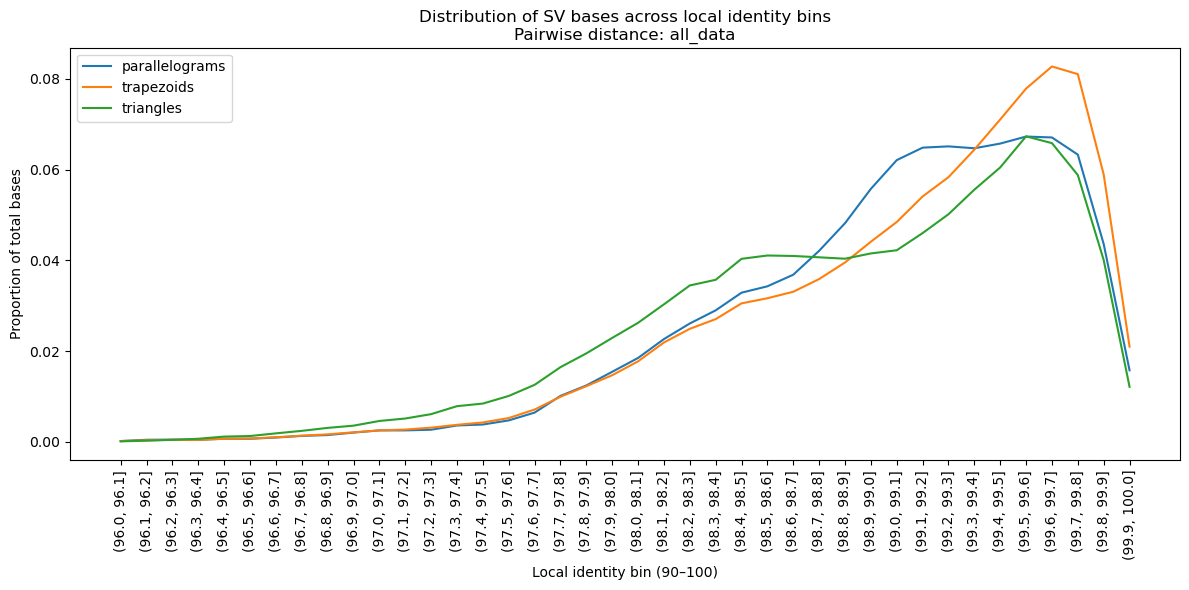

/data/tmp/ipykernel_2193045/3237246243.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["identity_bin"] = pd.cut(df_subset["local_identity"], bins=identity_bins, right=True)
/data/tmp/ipykernel_2193045/3237246243.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df_subset.groupby("identity_bin")[["parallelograms", "trapezoids", "triangles"]].sum()


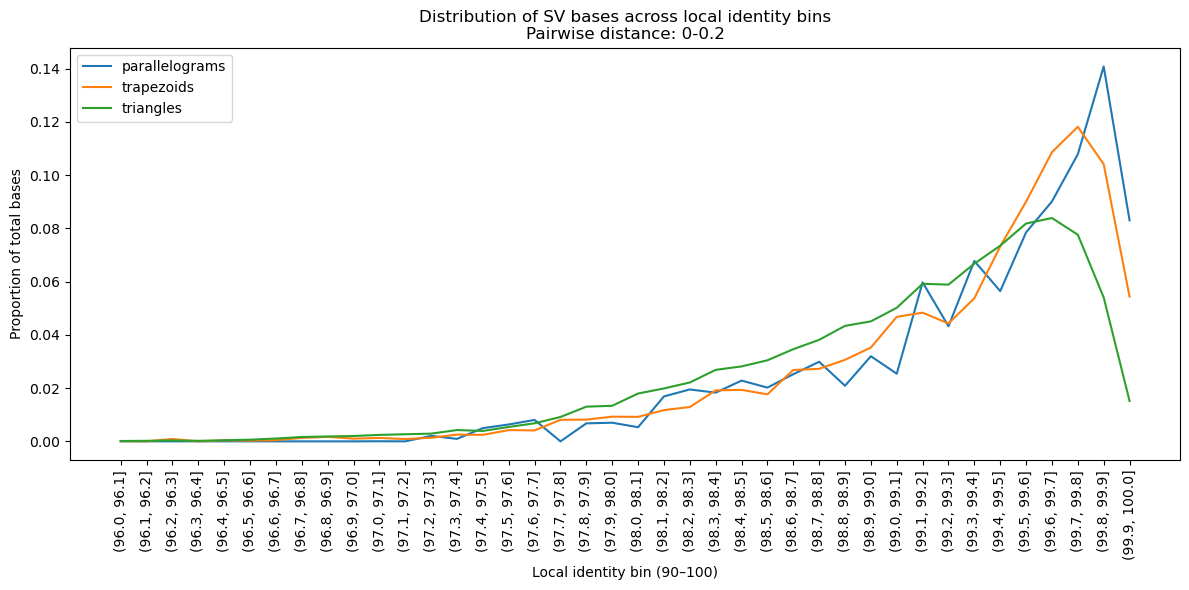

/data/tmp/ipykernel_2193045/3237246243.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["identity_bin"] = pd.cut(df_subset["local_identity"], bins=identity_bins, right=True)
/data/tmp/ipykernel_2193045/3237246243.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df_subset.groupby("identity_bin")[["parallelograms", "trapezoids", "triangles"]].sum()


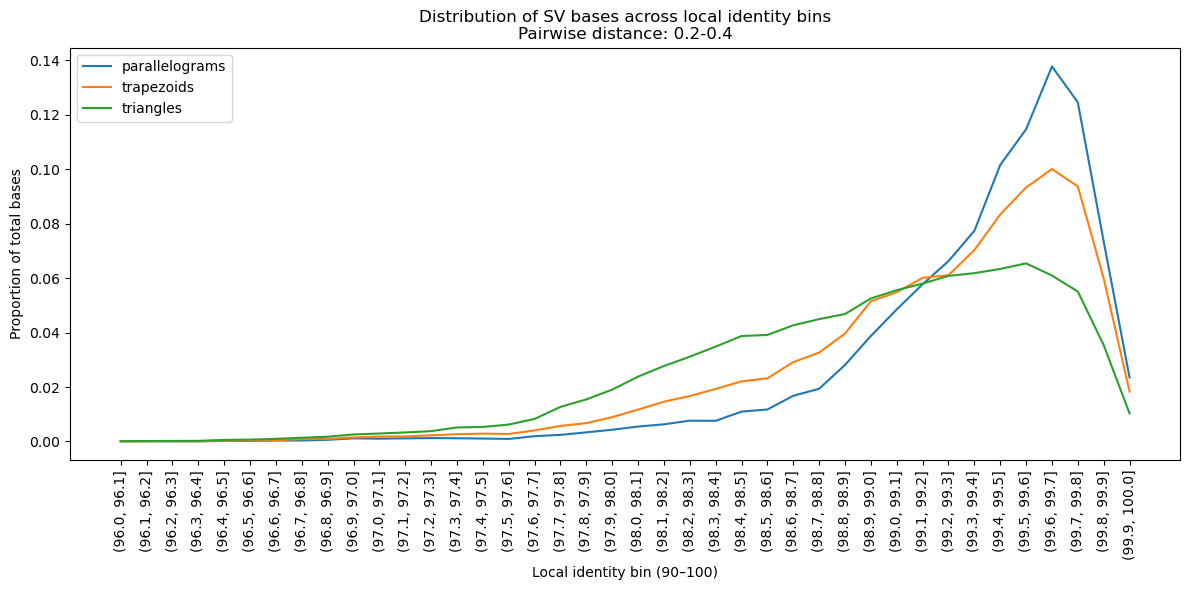

/data/tmp/ipykernel_2193045/3237246243.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["identity_bin"] = pd.cut(df_subset["local_identity"], bins=identity_bins, right=True)
/data/tmp/ipykernel_2193045/3237246243.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df_subset.groupby("identity_bin")[["parallelograms", "trapezoids", "triangles"]].sum()


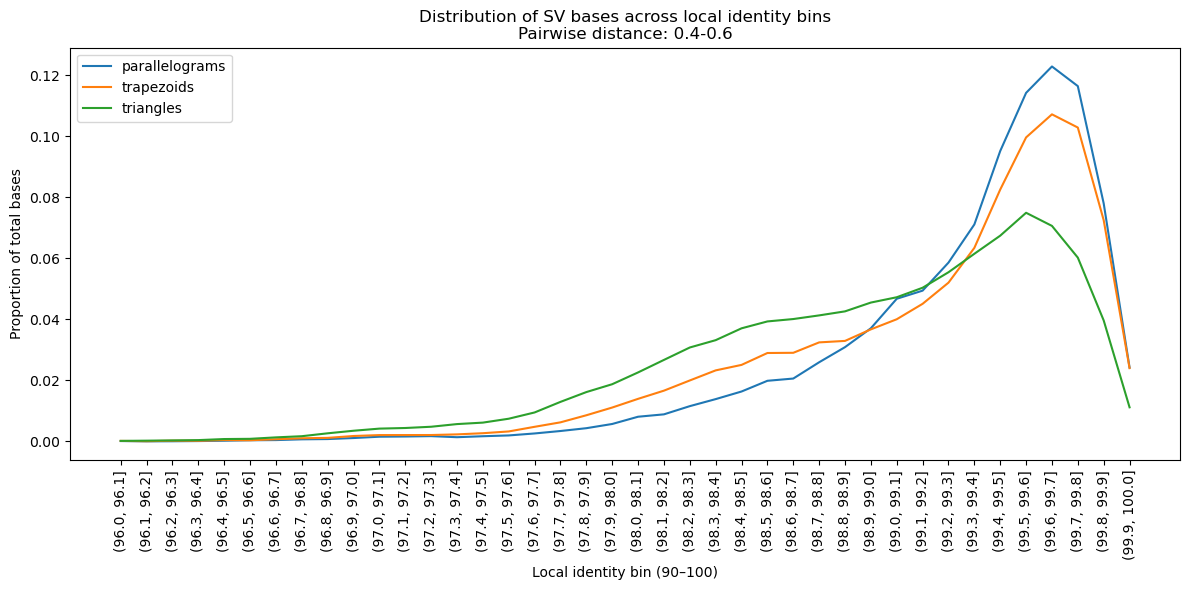

/data/tmp/ipykernel_2193045/3237246243.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["identity_bin"] = pd.cut(df_subset["local_identity"], bins=identity_bins, right=True)
/data/tmp/ipykernel_2193045/3237246243.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df_subset.groupby("identity_bin")[["parallelograms", "trapezoids", "triangles"]].sum()


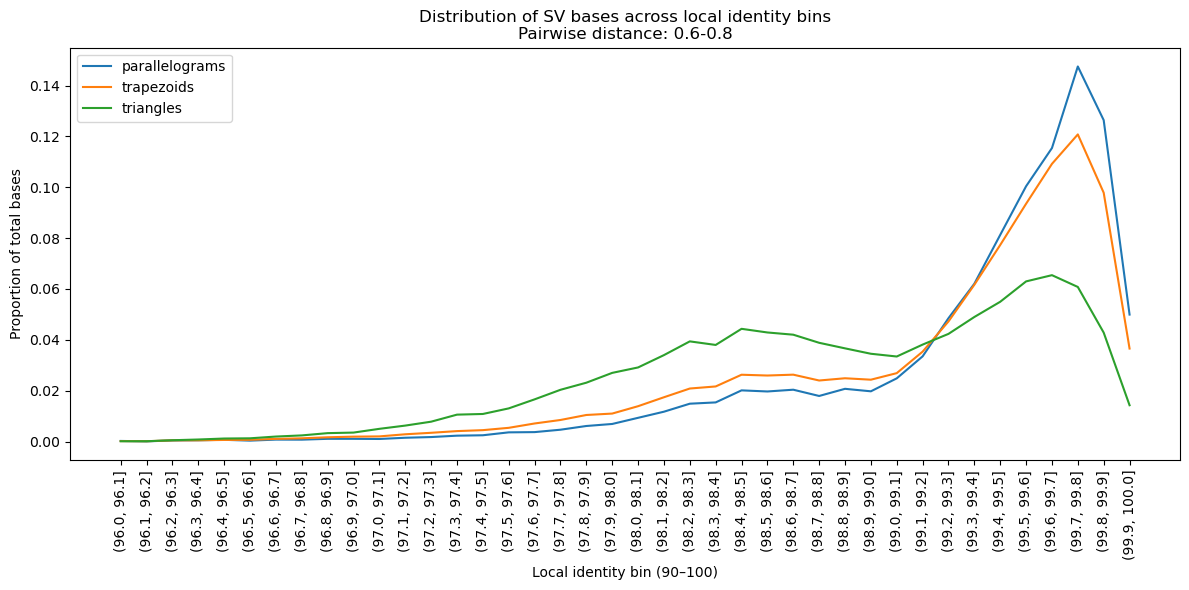

/data/tmp/ipykernel_2193045/3237246243.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["identity_bin"] = pd.cut(df_subset["local_identity"], bins=identity_bins, right=True)
/data/tmp/ipykernel_2193045/3237246243.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df_subset.groupby("identity_bin")[["parallelograms", "trapezoids", "triangles"]].sum()


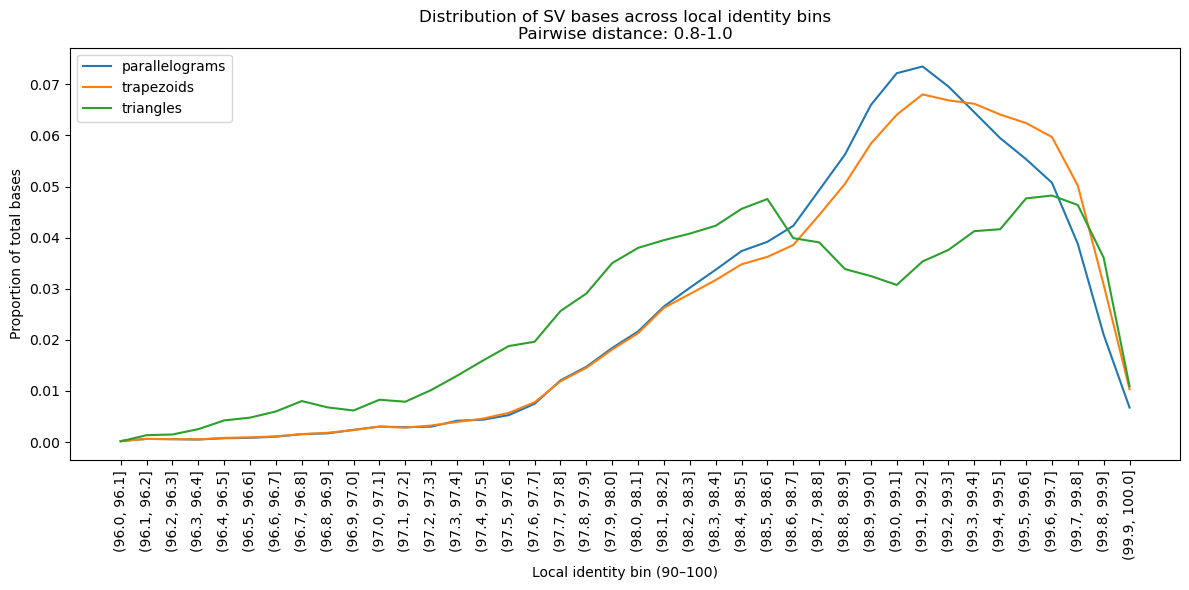

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the local identity bins (90–100, 40 bins)
identity_bins = np.linspace(96, 100, 41)  # 40 bins

# Define pairwise distance intervals
pairwise_intervals = [
    ("all_data", 0.0, 1.0),  # include all rows
    ("0-0.2", 0.0, 0.2),
    ("0.2-0.4", 0.2, 0.4),
    ("0.4-0.6", 0.4, 0.6),
    ("0.6-0.8", 0.6, 0.8),
    ("0.8-1.0", 0.8, 1.0)
]

# Loop over each interval
for label, low, high in pairwise_intervals:
    
    # Subset dataframe
    if label == "all_data":
        df_subset = df_local_sorted.copy()
    else:
        df_subset = df_local_sorted[(df_local_sorted["dist"] >= low) & (df_local_sorted["dist"] < high)]
    
    if df_subset.empty:
        print(f"No data in interval {label}, skipping.")
        continue
    
    # Bin local identity
    df_subset["identity_bin"] = pd.cut(df_subset["local_identity"], bins=identity_bins, right=True)
    
    # Sum base pairs per bin
    binned = df_subset.groupby("identity_bin")[["parallelograms", "trapezoids", "triangles"]].sum()
    
    # Compute proportions of total bases per category
    totals = binned.sum(axis=0)
    binned_prop = binned / totals
    
    # Plot
    plt.figure(figsize=(12, 6))
    for col, color in zip(
        ["parallelograms", "trapezoids", "triangles"],
        ["#1f77b4", "#ff7f0e", "#2ca02c"]
    ):
        plt.plot(binned_prop.index.astype(str), binned_prop[col], label=col, color=color)
    
    plt.ylabel("Proportion of total bases")
    plt.xlabel("Local identity bin (90–100)")
    plt.title(f"Distribution of SV bases across local identity bins\nPairwise distance: {label}")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

